In [1]:
import torch
from torch.autograd import Variable
from torch.autograd import grad
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import functions1d as fun


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
which = 'p3b'

### Real function:
$$x(t) = e^{-\lambda t}$$

In [3]:
real = fun.function[which]

### Trial function:
$$\hat{f(t)} = 1 + t * N(t)$$

where N(t) is a neural network with 1 input and 1 output

In [4]:
trial = fun.trial[which]

### Differential equation: 
$$\frac{\partial x}{\partial t} = - \lambda x$$

In [5]:
diff_eq = fun.diff_eq[which]
degree = fun.degree[which]

In [6]:
def g(t, nn):
    x = trial(nn, t)
    gx = []
    gradx, = grad([x], [t], grad_outputs=torch.ones(t.shape), create_graph=True)
    gx.append(gradx)
    if degree > 1:
        grad2x, = grad([gradx], [t], grad_outputs=torch.ones(t.shape), create_graph=True)
        gx.append(grad2x)
    z = diff_eq(t, x, gx)
    return z

Define range and neural network parameters

In [7]:
x_min, x_max = fun.interval[which]
n = 10
step = (x_max - x_min) / n

D_in, H, D_out = 1, 20, 1

### Training data: 
(unsupervised, no labels)

In [8]:
x_train = torch.arange(x_min, x_max, step).view(-1, 1)
x = Variable(x_train, requires_grad=True)

Define 
* the neural network architecture (1 hiddel layer, fully connected)
* the loss function (MSE)
* the optimizer (Adam)

In [9]:
seq = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    #torch.nn.ReLU(),
    torch.nn.LogSigmoid(),
    torch.nn.Linear(H, D_out)   
)

criterion = torch.nn.MSELoss(size_average=False)
#criterion = torch.nn.L1Loss(size_average=False)

optimizer = optim.Adam(seq.parameters(), lr=1e-4)

### Train the network

In [10]:
n_epoch = 30000
Loss = []
for t in tqdm(range(n_epoch)): 
    y = g(x, seq)
    loss = criterion(y, torch.zeros(y.shape))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    Loss.append(loss.data.numpy())

100%|██████████| 30000/30000 [00:23<00:00, 1251.74it/s]


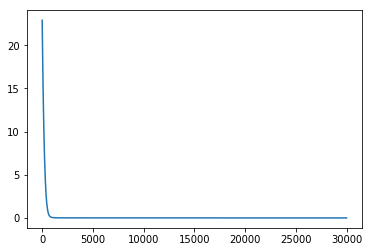

In [11]:
plt.plot(Loss)
plt.show()

### Test data:

In [16]:
x_test = torch.arange(x_min, x_max, 0.001).view(-1, 1)
xt = Variable(x_test*2, requires_grad=True)

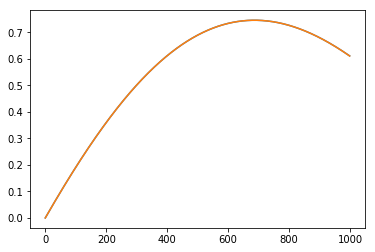

In [17]:
plt.plot(trial(seq, xt).data.numpy())
plt.plot(real(xt).data.numpy())
plt.show()

Difference between the real and the learned function: 

In [18]:
diff = trial(seq, xt) - real(xt)

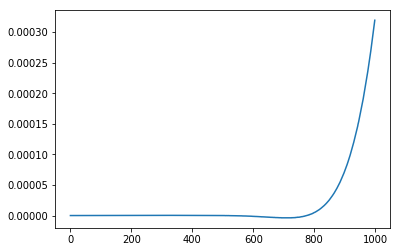

In [19]:
plt.plot(diff.data.numpy())
plt.show()